# **Прогнозирование заказов такси**  

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Создание-фичей" data-toc-modified-id="Создание-фичей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Создание фичей</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Линейка" data-toc-modified-id="Линейка-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейка</a></span></li><li><span><a href="#Дерево" data-toc-modified-id="Дерево-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Дерево</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Финальное-тестирование" data-toc-modified-id="Финальное-тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Финальное тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейка" data-toc-modified-id="Линейка-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейка</a></span></li><li><span><a href="#Дерево" data-toc-modified-id="Дерево-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Дерево</a></span></li><li><span><a href="#СatBoost" data-toc-modified-id="СatBoost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>СatBoost</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>


**Описание проекта**  
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.  
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  
**Инструкция по выполнению проекта**  
Загрузите данные и выполните их ресемплирование по одному часу.  
Проанализируйте данные.  
Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.  
Проверьте данные на тестовой выборке и сделайте выводы.  
**Описание данных**  
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor

## Обзор данных

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv',  index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
df.index.is_monotonic

True

Даты непрерыыные

In [3]:
df = df.resample('1H').sum()

In [5]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


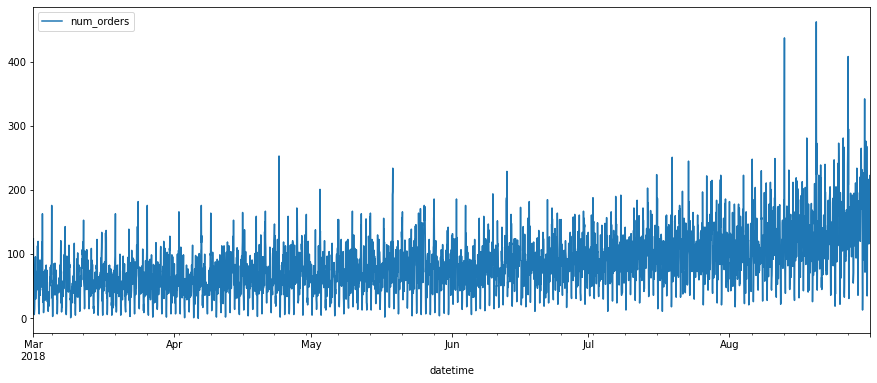

In [4]:
df.plot(figsize=(15,6));

На таком маштабе не особо понятно, что у нас с данными, по-этому разобьем его на тренд и сезонность

## Анализ данных

In [5]:
def decompose_interval(df):
    fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
    axs[0].plot(decomposed.trend)
    axs[0].set_title("Тренд")

    axs[1].plot(decomposed.seasonal)
    axs[1].set_title("Сезонность")

    axs[2].plot(decomposed.resid)
    axs[2].set_title("Остаток")

    plt.show()

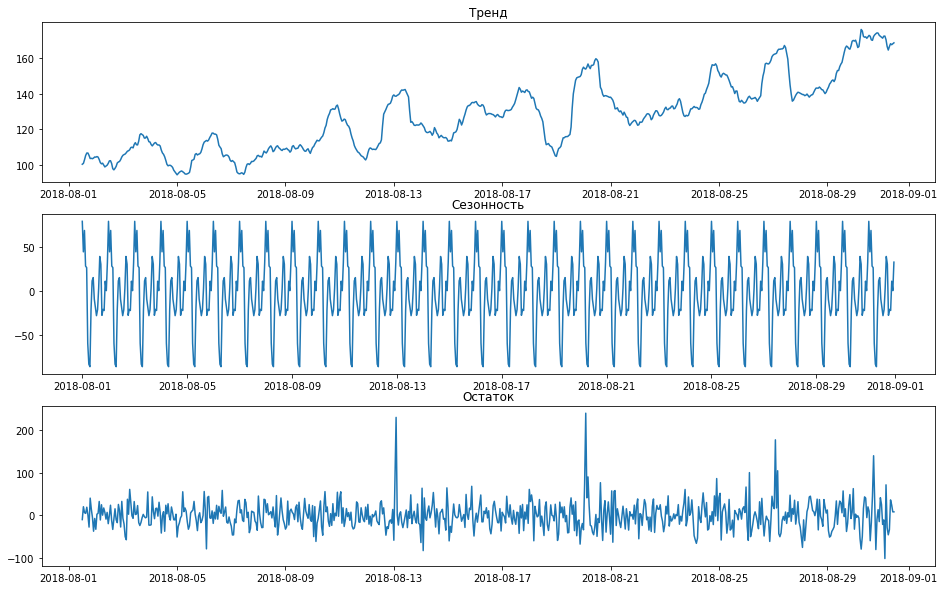

In [6]:
decomposed = seasonal_decompose(df['2018-08-01':'2018-08-31'])
decompose_interval(decomposed)

У временого ряда имеется тренд- увеличение кол-ва вызовов такси. Чтобы рассмотреть тренд, увеличим маштаб  

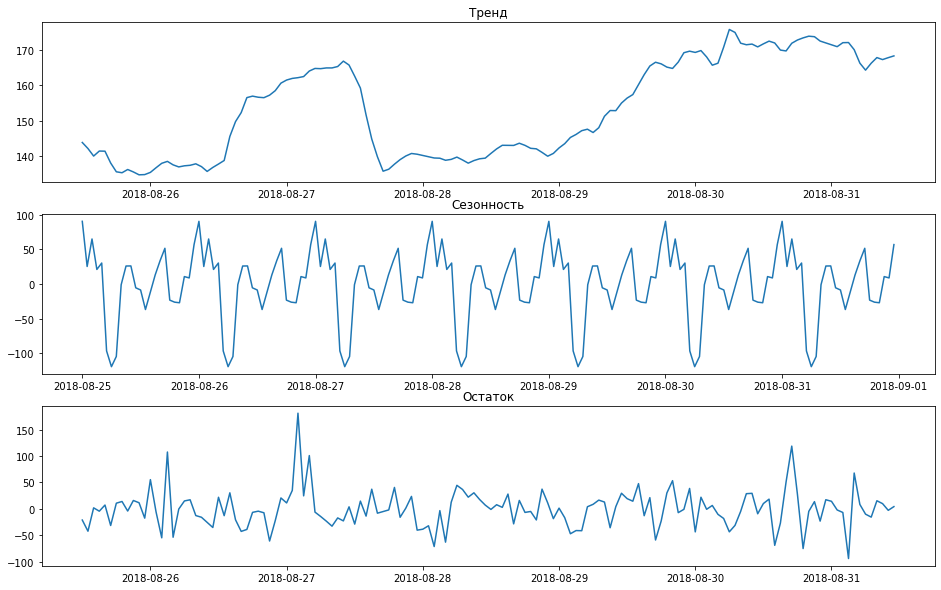

In [9]:
decomposed = seasonal_decompose(df['2018-08-25':'2018-08-31'])
decompose_interval(decomposed)

Так уже лучше, но стоит расмотреть один день, чтобы разобрать сезонность

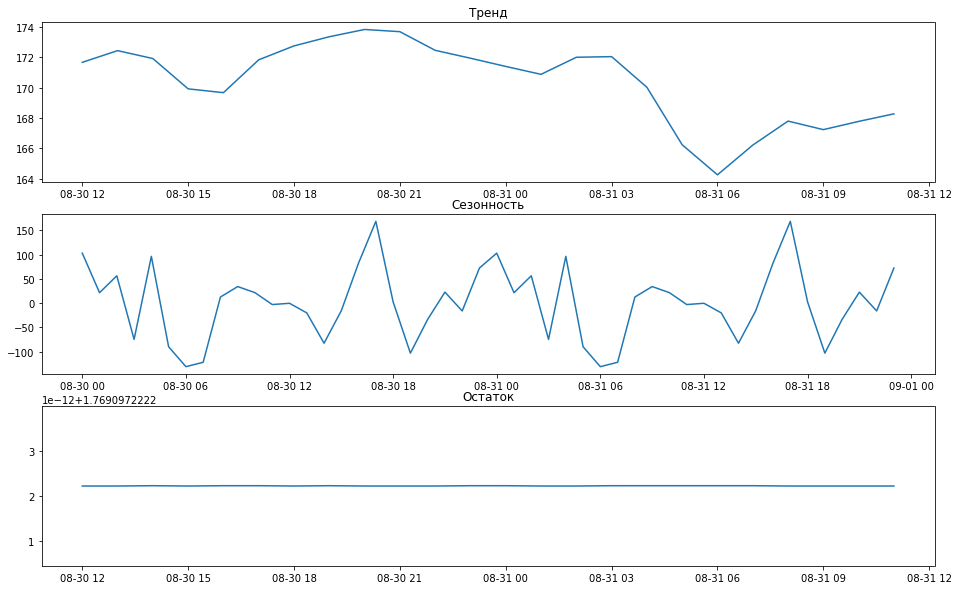

In [10]:
decomposed = seasonal_decompose(df['2018-08-30':'2018-08-31'])
decompose_interval(decomposed)

Видим сезонность временого ряда: рост вызовов в течение рабочего дня и минимумом в 6 утра

### Выводы

Видим, что данные подвержены тренду, кол-во вызовов постепенно растет, изменяется среднее и дисперсия, а значит временной ряд не стационарен.

Чтобы ряд сделать стационарным, найдём разности его значений

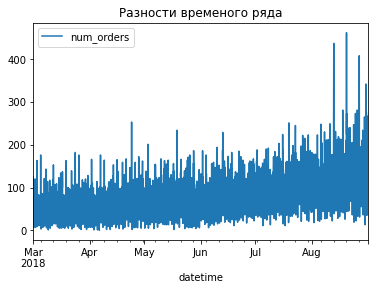

In [11]:
#df_shift = (df - df.shift()).dropna()
df_shift = df
df_shift.plot()

plt.title('Разности временого ряда');

In [12]:
from statsmodels.tsa.stattools import adfuller

Н0: "Временной ряд является нестацинарным". H1: "Временной ряд стационарен"

In [13]:
p_value = adfuller(df['num_orders'])[1]
print(f'P = {p_value}')
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.02894005140261409
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Ряд стал более стационарным

## Создание фичей

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofweek'] = new_df.index.dayofweek
    #new_df['month'] = new_df.index.month
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_df

In [12]:
df_1 = df.resample("1d").sum()

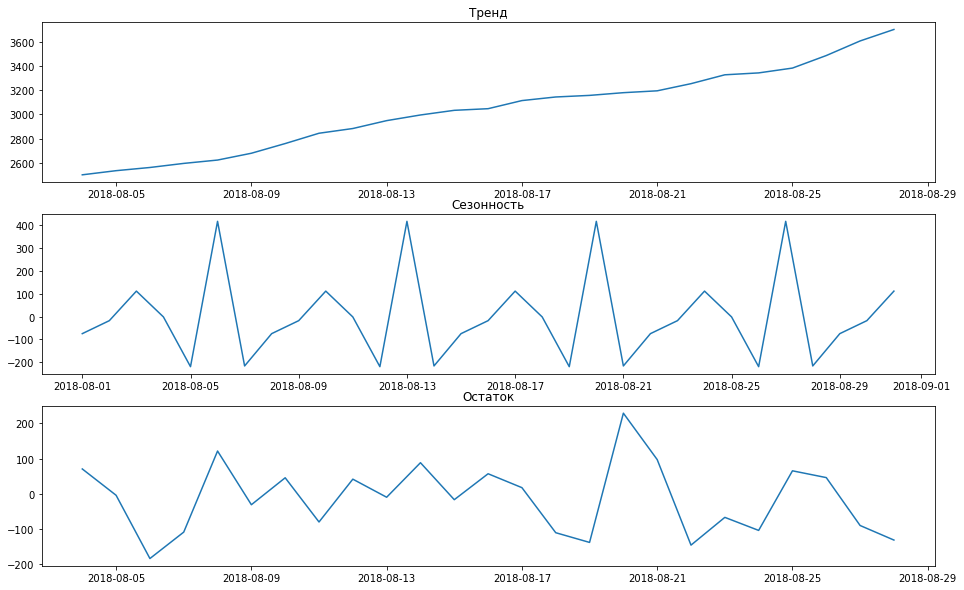

In [13]:
decomposed = seasonal_decompose(df_1['2018-08-01':'2018-08-31'])
decompose_interval(decomposed)

Подберем max_lag как разницу в часах между ежеднеыным пиком и минимумом заказов.  
Подберем rolling_mean_size c минимальным RMSE

In [15]:
'''best_rmse = 1000
best_rolling_mean_size = 0
for rolling_mean_size in range(2,49):
    data = df_shift['2018-08-30':'2018-08-31'].copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    rmse = mean_squared_error(num_orders,rolling_mean, squared=False)
    if rmse < best_rmse:
        best_rmse =rmse
        best_rolling_mean_size = rolling_mean_size
best_rolling_mean_size'''
'Этот способ показал результат хуже.'

'Этот способ показал результат хуже.'

In [16]:
'''%%time
best_rmse = 1000
for i in range(1,50):
    for j in range(1,50):
        new_df = make_features(df_shift, i, j)
        
        train, test = train_test_split(new_df, shuffle=False, test_size=0.2)
        train.dropna(inplace=True)
        
        X = train.columns[1:]
        y = ['num_orders']
        
        lr = LinearRegression()
        lr.fit(train[X], train[y])

        preds = lr.predict(train[X])
        
        rmse = mean_squared_error(preds, train[y], squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_i = i
            best_j = j
print("RMSE:", best_rmse, "\n max_lag:", best_i, "\n rolling_mean_size:", best_j)'''
''

''

RMSE: 22.21727946129832   
 max_lag: 49   
 rolling_mean_size: 42  

In [17]:
new_df = make_features(df_shift, 49, 42)

## Обучение модели

### Линейка

In [18]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1, random_state=42)
train.dropna(inplace=True)
        
X = train.columns[1:]
y = ['num_orders']


In [19]:
model = LinearRegression()
param_search = {}
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(model, param_grid=param_search, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(train[X], train[y])
print(f'Лучшее RMSE на 3х фолдах: {abs(grid.best_score_)}')

Лучшее RMSE на 3х фолдах: 24.740011206945603


### Дерево


In [20]:
dtr = DecisionTreeRegressor(random_state=42)
param_search = {'max_depth': range(1,15)}
grid = GridSearchCV(dtr, param_grid=param_search, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(train[X], train[y])
grid.best_params_

{'max_depth': 5}

In [21]:
dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
dtr.fit(train[X], train[y])

preds = dtr.predict(train[X])
print(f'RMSE: {mean_squared_error(preds, train[y], squared=False)}')

RMSE: 24.024247438018737


### CatBoost

In [22]:
df_cat = ['hour', 'dayofweek']

In [23]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=df_cat
                 )

test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=df_cat
                 )

In [24]:
'''params = {'cat_features': df_cat,
          'loss_function': 'RMSE',
              'random_seed': 42,
              'verbose':100}'''
''

''

In [25]:
'''%%time
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    verbose=False,
    plot="True"
)'''
''

''

In [26]:
params = {'learning_rate':[0.005, 0.1],
                'random_state':[42],
                'verbose':[False]}

In [27]:
'''model = CatBoostRegressor()
grid = GridSearchCV(model, param_grid=params, cv=tscv, scoring='neg_root_mean_squared_error')
grid.fit(train[X], train[y])
print(f'Лучшее RMSE на 3х фолдах: {abs(grid.best_score_)}')
grid.best_params_'''
''

Лучшее RMSE на 3х фолдах: 23.738991996553416


In [28]:
grid.best_params_

{'learning_rate': 0.1, 'random_state': 42, 'verbose': False}

## Финальное тестирование

### Линейка

In [29]:
lr = LinearRegression()
lr.fit(train[X], train[y])

preds = lr.predict(test[X])
print(f'RMSE: {mean_squared_error(preds, test[y], squared=False)}')

RMSE: 41.853197909832


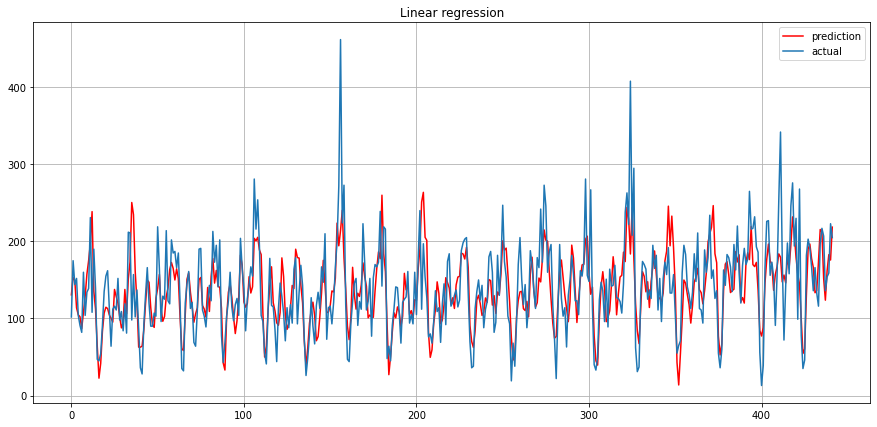

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(preds, "r", label="prediction")
plt.plot(test[y].values, label="actual")
plt.legend()
plt.title("Linear regression")
plt.grid(True);

### Дерево

In [31]:
dtr = DecisionTreeRegressor(max_depth = 5, random_state=42)
dtr.fit(train[X], train[y])

preds = dtr.predict(test[X])
print(f'RMSE: {mean_squared_error(preds, test[y], squared=False)}')

RMSE: 56.195491624681914


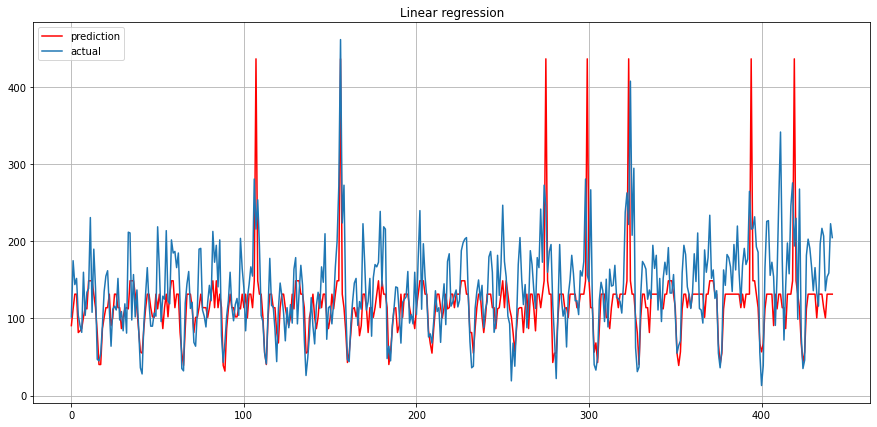

In [32]:
plt.figure(figsize=(15, 7))
plt.plot(preds, "r", label="prediction")
plt.plot(test[y].values, label="actual")
plt.legend()
plt.title("Linear regression")
plt.grid(True);

### СatBoost

In [33]:
model = CatBoostRegressor(learning_rate= 0.1, random_state=42, verbose=100)
model.fit(train[X], train[y])

preds = model.predict(test[X])
print(f'RMSE: {mean_squared_error(preds, test[y], squared=False)}')

0:	learn: 36.7878777	total: 7.48ms	remaining: 7.47s
100:	learn: 18.8835718	total: 802ms	remaining: 7.14s
200:	learn: 15.6326227	total: 1.55s	remaining: 6.18s
300:	learn: 13.2505645	total: 2.29s	remaining: 5.31s
400:	learn: 11.5695708	total: 3.03s	remaining: 4.53s
500:	learn: 10.0732166	total: 3.87s	remaining: 3.86s
600:	learn: 8.8809901	total: 4.61s	remaining: 3.06s
700:	learn: 7.8755241	total: 5.42s	remaining: 2.31s
800:	learn: 6.9597041	total: 6.21s	remaining: 1.54s
900:	learn: 6.1281424	total: 6.97s	remaining: 766ms
999:	learn: 5.4179933	total: 7.76s	remaining: 0us
RMSE: 40.544553243802895


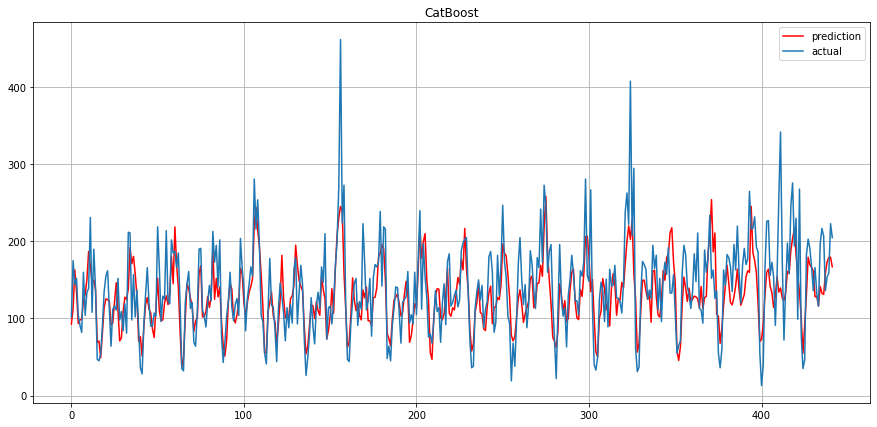

In [34]:
plt.figure(figsize=(15, 7))
plt.plot(preds, "r", label="prediction")
plt.plot(test[y].values, label="actual")
plt.legend()
plt.title("CatBoost")
plt.grid(True);

## Вывод

Мы исследовали данные, сделали временой ряд более стационарным, выбрали лучшее кол-во фичей для датасета и обучили модель с этими фичами.
Лучшее RMSE на тестовой выборке у CatBoost = 39.31